In [25]:
from intake import open_catalog

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Import tobac itself
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.5.5


In [3]:
# Open EUREC4A catalogue to access data
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

In [4]:
# Open the cloud botany LES catalogue
cloud_botany = cat.simulations.DALES.botany

In [48]:
# Load 2D cloud fields into an xarray dataset
ds = cloud_botany.dx100m.nx1536["2D"].to_dask()
# Supress FutureWarning

In [49]:
ds

<xarray.Dataset> Size: 8TB
Dimensions:    (member: 103, time: 720, yt: 1536, xt: 1536)
Coordinates:
  * member     (member) int32 412B 1 2 3 4 5 6 7 8 ... 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 6kB 2020-02-01T00:05:00 ... 2020-02-03T1...
  * xt         (xt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
  * yt         (yt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
Data variables:
    capemax    (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cinmax     (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cldtop     (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hinvsrf    (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hmix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    lwp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    rwp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    surfprec   (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    thetavmix  (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    twp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    umix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    vmix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

In [50]:
# Load a subset of LWP for one ensemble member
lwp = ds.sel(member=42, time=slice(datetime(2020,2,2,10), datetime(2020,2,2,14))).lwp.compute()

In [51]:
lwp

<xarray.DataArray 'lwp' (time: 49, yt: 1536, xt: 1536)> Size: 462MB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.00102831, 0.        , 0.        , ..., 0.00491316,
         0.00562901, 0.00219619],
        [0.00414839, 0.0058143 , 0.        , ..., 0.        ,
         0.00132997, 0.00294653],
        [0.00496258, 0.01563594, 0.00805975, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00027151, 0.        , 0.        , ..., 0.        ,
         0.00519815, 0.0106766 ],
        [0.00014908, 0.        , 0.        , ..., 0.        ,
         0.00114155, 0.00482762],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    member   int32 4B 42
  * time     (time) datetime64[ns] 392B 2020-02-02T10:00:00 ... 2020-02-02T14...
  * xt       (xt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
  * yt       (yt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
Attributes:
    longname:  xy crosssections liquid water path
    units:     kg/m^2

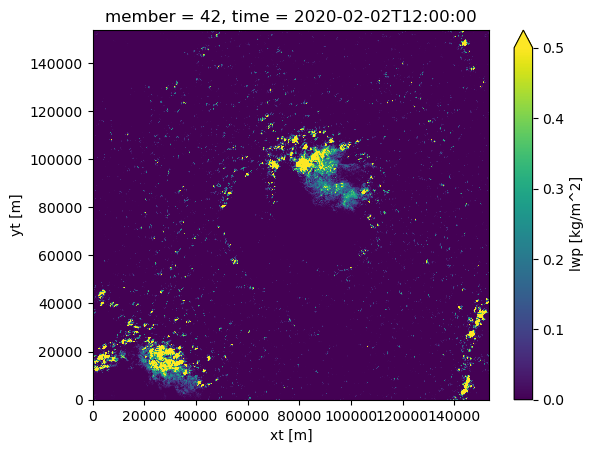

In [53]:
lwp[24].plot(vmax=0.5)

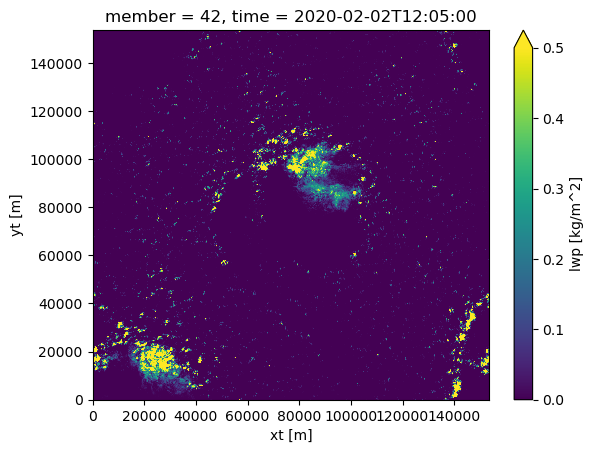

In [54]:
lwp[25].coarsen({"yt":10, "xt":10}.plot(vmax=0.5)

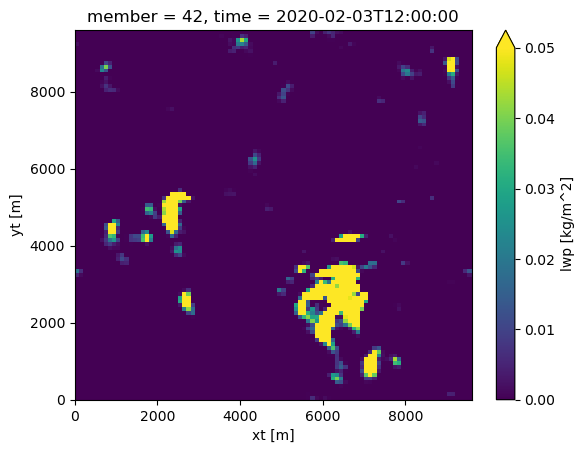

In [8]:
lwp[24].plot(vmax=0.05)

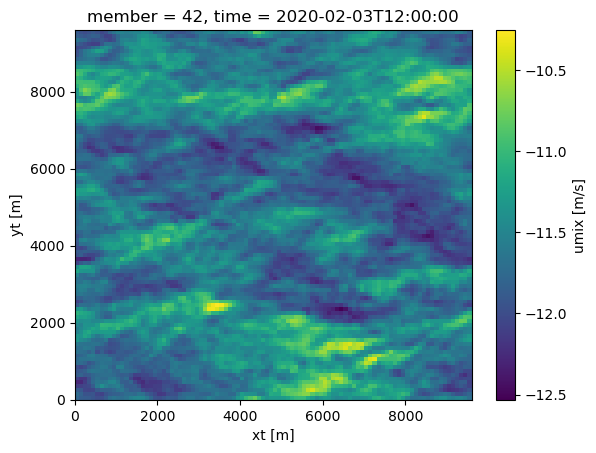

In [46]:
ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).umix[24].plot()

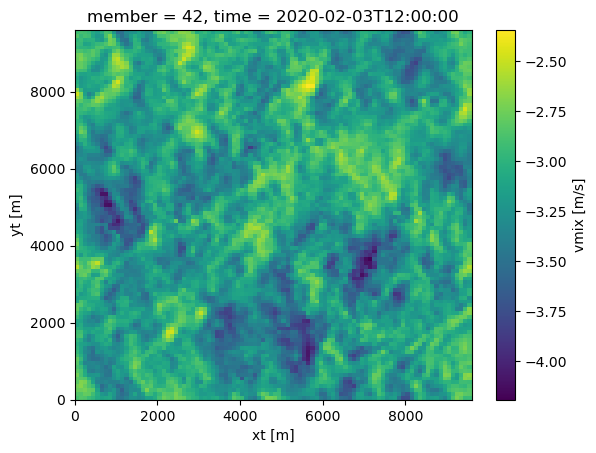

In [47]:
ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).vmix[24].plot()

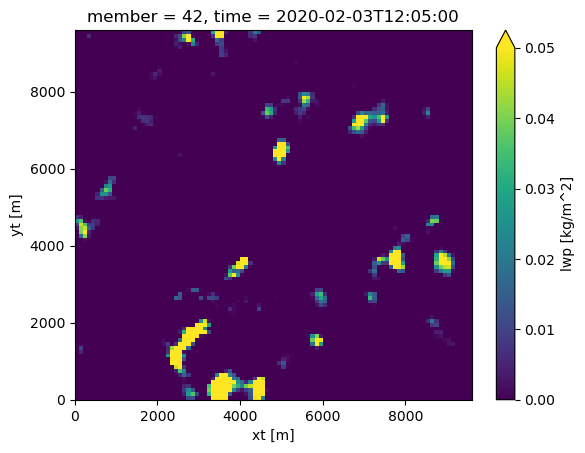

In [9]:
lwp[25].plot(vmax=0.05)

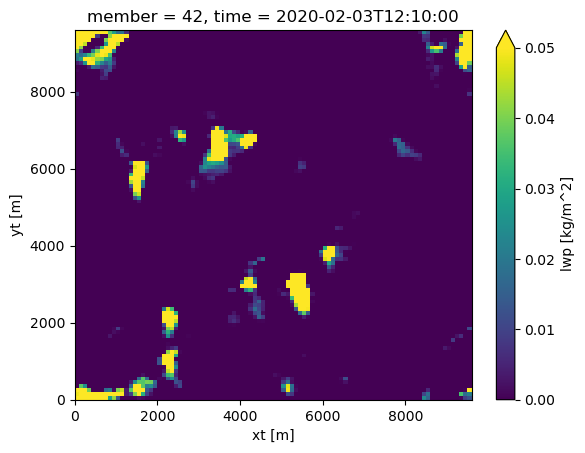

In [10]:
lwp[26].plot(vmax=0.05)

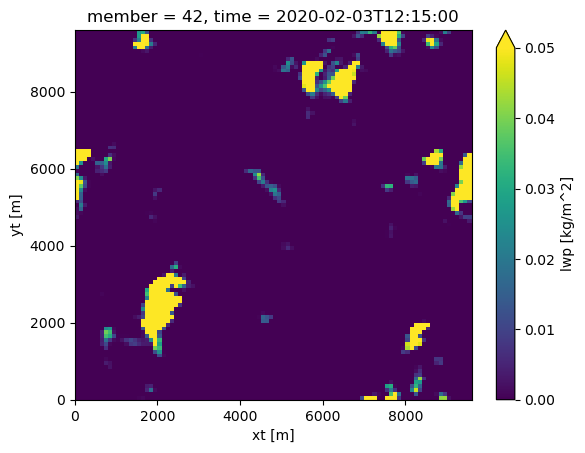

In [11]:
lwp[27].plot(vmax=0.05)

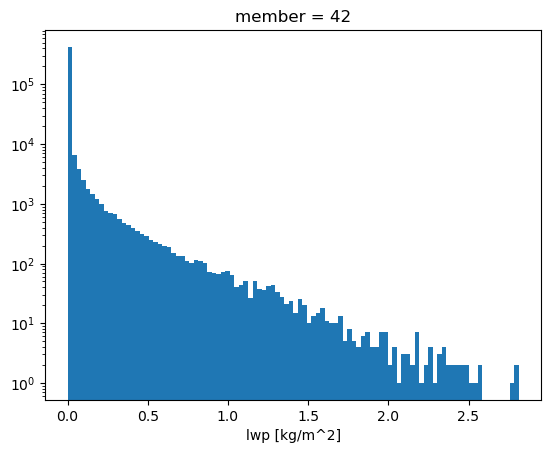

In [12]:
lwp.plot(bins=100)
plt.yscale("log")

In [13]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['threshold']=[0.05, 0.125, 0.25] #kg/m^2
parameters_features['n_min_threshold']=4


In [14]:
import warnings

In [15]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
Features = tobac.feature_detection_multithreshold(
    lwp, dxy=100, threshold=[0.05, 0.125, 0.25], min_num=4, PBC_flag="both"
)

In [17]:
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member
0,0,1,23.500000,59.500000,4,0.050,1,2020-02-03 10:00:00,2020-02-03 10:00:00,2400.000000,6000.000000,6000.000000
1,0,2,33.500000,19.500000,4,0.050,2,2020-02-03 10:00:00,2020-02-03 10:00:00,3400.000000,2000.000000,2000.000000
2,0,3,34.714494,67.379389,21,0.050,3,2020-02-03 10:00:00,2020-02-03 10:00:00,3521.449409,6787.938949,6787.938949
3,0,4,36.500000,31.000000,2,0.050,4,2020-02-03 10:00:00,2020-02-03 10:00:00,3700.000000,3150.000000,3150.000000
4,0,6,42.000000,71.500000,2,0.050,5,2020-02-03 10:00:00,2020-02-03 10:00:00,4250.000000,7200.000000,7200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
816,48,30,78.700275,2.200103,10,0.125,817,2020-02-03 14:00:00,2020-02-03 14:00:00,7920.027460,270.010288,270.010288
817,48,32,25.000000,0.000000,1,0.250,818,2020-02-03 14:00:00,2020-02-03 14:00:00,2550.000000,50.000000,50.000000
818,48,33,37.750201,47.250067,8,0.250,819,2020-02-03 14:00:00,2020-02-03 14:00:00,3825.020099,4775.006695,4775.006695
819,48,34,40.000000,29.000000,1,0.250,820,2020-02-03 14:00:00,2020-02-03 14:00:00,4050.000000,2950.000000,2950.000000


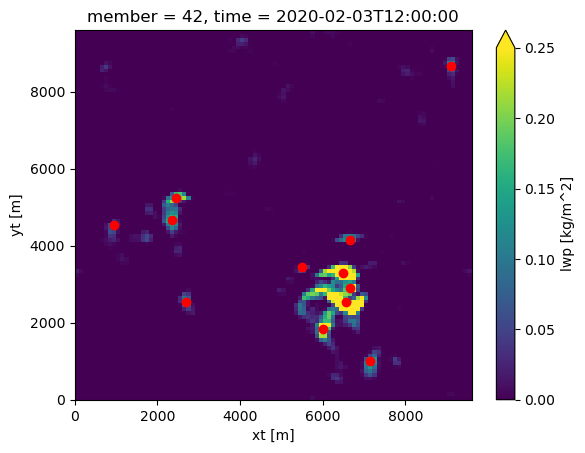

In [18]:
lwp[24].plot(vmax=0.25)
plt.scatter(Features[Features.frame==24].xt, Features[Features.frame==24].yt, c="red")

In [21]:
Tracks = tobac.linking_trackpy(
    Features, None, dt=300, dxy=100, v_max=10, method_linking="predict", 
    adaptive_stop=0.2, 
    adaptive_step=0.95, 
    stubs=4,
    # subnetwork_size=100,
    min_h1=0,
    max_h1=96,
    min_h2=0,
    max_h2=96,
    PBC_flag='both',
)

Frame 48: 17 trajectories present.


In [26]:
np.unique(Tracks.cell)

array([ -1,   3,   4,   5,   7,  16,  25,  26,  27,  32,  34,  36,  37,
        38,  39,  44,  45,  48,  50,  52,  54,  57,  61,  63,  64,  65,
        68,  69,  71,  72,  73,  79,  80,  83,  85,  86,  91,  92,  93,
        94,  95,  98, 101, 104, 107, 110, 111, 114, 117, 119, 121, 125,
       126, 128, 129, 138, 145, 146, 147, 149, 152, 156, 160, 162, 164,
       169, 172, 173, 176, 187, 188, 189, 190, 192, 198, 201, 202, 203,
       205, 213, 221])

In [28]:
Tracks[Tracks.cell==4]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,cell,time_cell
3,0,4,36.500000,31.000000,2,0.050,4,2020-02-03 10:00:00,2020-02-03 10:00:00,3700.000000,3150.000000,3150.000000,4,0 days 00:00:00
22,1,11,38.000000,35.000000,1,0.050,23,2020-02-03 10:05:00,2020-02-03 10:05:00,3850.000000,3550.000000,3550.000000,4,0 days 00:05:00
36,2,7,36.666720,29.333280,3,0.050,37,2020-02-03 10:10:00,2020-02-03 10:10:00,3716.671957,2983.328043,2983.328043,4,0 days 00:10:00
51,3,8,29.799897,2.399966,5,0.050,52,2020-02-03 10:15:00,2020-02-03 10:15:00,3029.989712,289.996572,289.996572,4,0 days 00:15:00
74,4,21,24.444319,63.333439,9,0.125,75,2020-02-03 10:20:00,2020-02-03 10:20:00,2494.431888,6383.343914,6383.343914,4,0 days 00:20:00
104,5,47,21.000000,27.500000,2,0.250,105,2020-02-03 10:25:00,2020-02-03 10:25:00,2150.000000,2800.000000,2800.000000,4,0 days 00:25:00
109,6,6,21.111162,91.444319,9,0.050,110,2020-02-03 10:30:00,2020-02-03 10:30:00,2161.116207,9194.431888,9194.431888,4,0 days 00:30:00
125,7,5,26.500000,58.500000,4,0.050,126,2020-02-03 10:35:00,2020-02-03 10:35:00,2700.000000,5900.000000,5900.000000,4,0 days 00:35:00
147,8,27,19.500000,21.500000,4,0.125,148,2020-02-03 10:40:00,2020-02-03 10:40:00,2000.000000,2200.000000,2200.000000,4,0 days 00:40:00
174,9,35,12.940625,67.594522,69,0.250,175,2020-02-03 10:45:00,2020-02-03 10:45:00,1344.062463,6809.452220,6809.452220,4,0 days 00:45:00


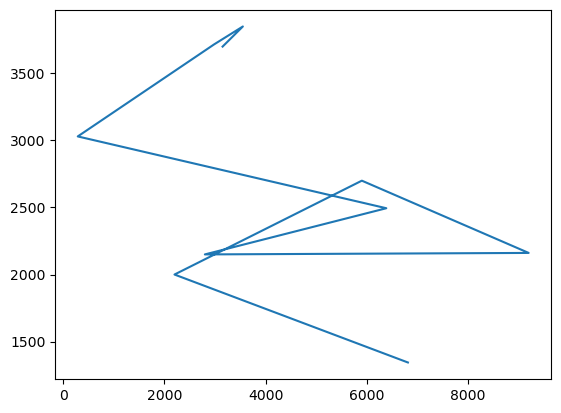

In [29]:
plt.plot(Tracks[Tracks.cell==4].xt, Tracks[Tracks.cell==4].yt)

In [30]:
twp = ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).twp.compute()

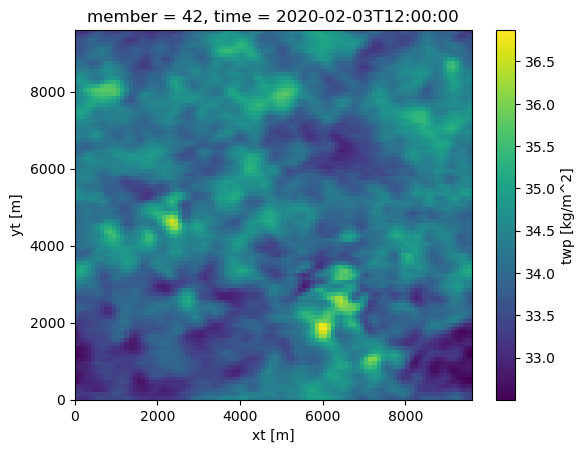

In [31]:
twp[24].plot()

In [32]:
rwp = ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).rwp.compute()

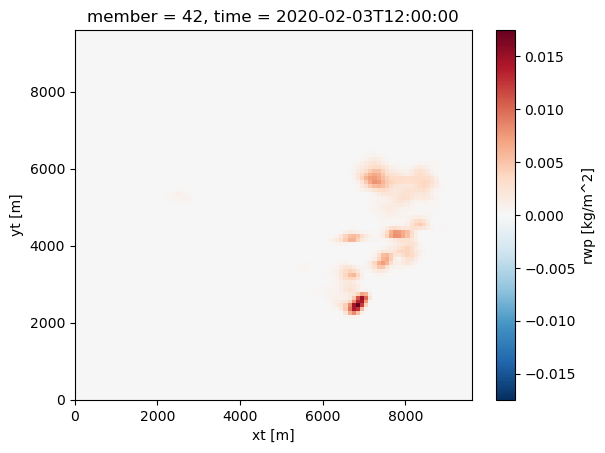

In [33]:
rwp[24].plot()

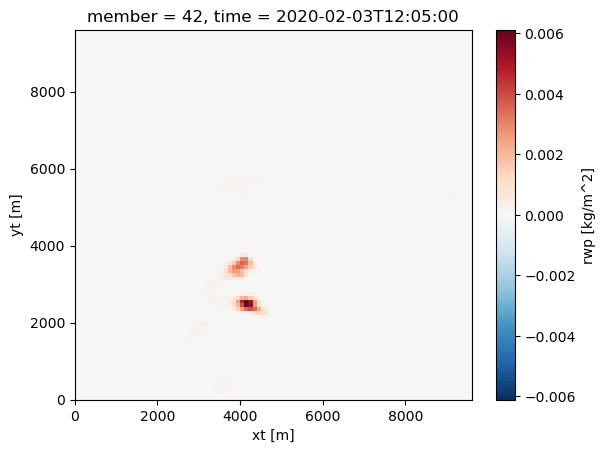

In [34]:
rwp[25].plot()

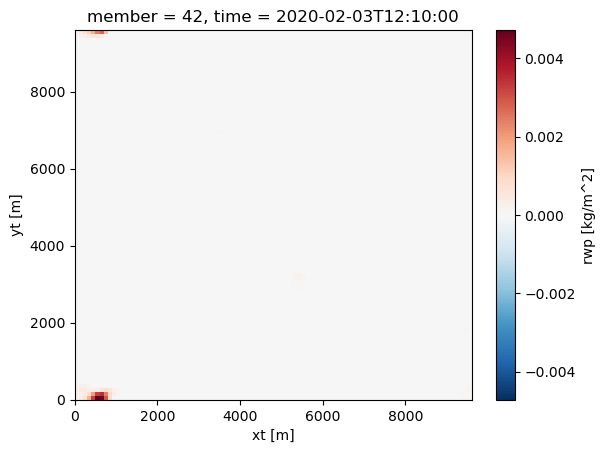

In [35]:
rwp[26].plot()

In [36]:
Features = tobac.feature_detection_multithreshold(
    rwp, dxy=100, threshold=[0.002, 0.005, 0.01], min_num=4, PBC_flag="both"
)

In [37]:
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member
0,3,3,9.500000,37.000000,2,0.005,1,2020-02-03 10:15:00,2020-02-03 10:15:00,1000.000000,3750.000000,3750.000000
1,4,1,8.200103,10.600034,5,0.002,2,2020-02-03 10:20:00,2020-02-03 10:20:00,870.010288,1110.003428,1110.003428
2,4,2,20.750067,44.000000,4,0.002,3,2020-02-03 10:20:00,2020-02-03 10:20:00,2125.006695,4450.000000,4450.000000
3,5,1,4.000000,61.000000,1,0.002,4,2020-02-03 10:25:00,2020-02-03 10:25:00,450.000000,6150.000000,6150.000000
4,5,2,10.000000,55.000000,1,0.002,5,2020-02-03 10:25:00,2020-02-03 10:25:00,1050.000000,5550.000000,5550.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
177,46,10,34.333280,45.333280,3,0.010,178,2020-02-03 13:50:00,2020-02-03 13:50:00,3483.328043,4583.328043,4583.328043
178,46,11,68.600034,43.200103,5,0.010,179,2020-02-03 13:50:00,2020-02-03 13:50:00,6910.003428,4370.010288,4370.010288
179,47,1,24.500000,30.000000,6,0.002,180,2020-02-03 13:55:00,2020-02-03 13:55:00,2500.000000,3050.000000,3050.000000
180,48,1,23.000000,5.000000,1,0.002,181,2020-02-03 14:00:00,2020-02-03 14:00:00,2350.000000,550.000000,550.000000


In [40]:
Tracks = tobac.linking_trackpy(
    Features, None, dt=300, dxy=100, v_max=15, method_linking="predict", 
    adaptive_stop=0.2, 
    adaptive_step=0.95, 
    stubs=4,
    # subnetwork_size=100,
    min_h1=0,
    max_h1=96,
    min_h2=0,
    max_h2=96,
    PBC_flag='both',
)

Frame 48: 2 trajectories present.


In [41]:
Tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,cell,time_cell
0,3,3,9.500000,37.000000,2,0.005,1,2020-02-03 10:15:00,2020-02-03 10:15:00,1000.000000,3750.000000,3750.000000,-1,NaT
1,4,1,8.200103,10.600034,5,0.002,2,2020-02-03 10:20:00,2020-02-03 10:20:00,870.010288,1110.003428,1110.003428,-1,NaT
2,4,2,20.750067,44.000000,4,0.002,3,2020-02-03 10:20:00,2020-02-03 10:20:00,2125.006695,4450.000000,4450.000000,-1,NaT
3,5,1,4.000000,61.000000,1,0.002,4,2020-02-03 10:25:00,2020-02-03 10:25:00,450.000000,6150.000000,6150.000000,-1,NaT
4,5,2,10.000000,55.000000,1,0.002,5,2020-02-03 10:25:00,2020-02-03 10:25:00,1050.000000,5550.000000,5550.000000,-1,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,46,10,34.333280,45.333280,3,0.010,178,2020-02-03 13:50:00,2020-02-03 13:50:00,3483.328043,4583.328043,4583.328043,38,0 days 00:20:00
178,46,11,68.600034,43.200103,5,0.010,179,2020-02-03 13:50:00,2020-02-03 13:50:00,6910.003428,4370.010288,4370.010288,37,0 days 00:40:00
179,47,1,24.500000,30.000000,6,0.002,180,2020-02-03 13:55:00,2020-02-03 13:55:00,2500.000000,3050.000000,3050.000000,33,0 days 00:50:00
180,48,1,23.000000,5.000000,1,0.002,181,2020-02-03 14:00:00,2020-02-03 14:00:00,2350.000000,550.000000,550.000000,33,0 days 00:55:00


In [42]:
np.unique(Tracks.cell)

array([-1,  4,  5,  6,  7, 10, 11, 14, 17, 18, 19, 20, 29, 32, 33, 37, 38,
       39])

In [43]:
Tracks[Tracks.cell==4]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,cell,time_cell
6,5,8,43.368282,4.894493,19,0.010,7,2020-02-03 10:25:00,2020-02-03 10:25:00,4386.828225,539.449281,539.449281,4,0 days 00:00:00
7,6,5,42.582089,74.445261,110,0.010,8,2020-02-03 10:30:00,2020-02-03 10:30:00,4308.208907,7494.526144,7494.526144,4,0 days 00:05:00
10,7,9,42.500000,47.500000,6,0.010,11,2020-02-03 10:35:00,2020-02-03 10:35:00,4300.000000,4800.000000,4800.000000,4,0 days 00:10:00
14,8,9,35.545506,13.818143,11,0.005,15,2020-02-03 10:40:00,2020-02-03 10:40:00,3604.550607,1431.814327,1431.814327,4,0 days 00:15:00
17,9,2,58.727125,83.726983,11,0.002,18,2020-02-03 10:45:00,2020-02-03 10:45:00,5922.712458,8422.698266,8422.698266,4,0 days 00:20:00
23,10,14,7.666720,44.333280,3,0.010,24,2020-02-03 10:50:00,2020-02-03 10:50:00,816.671957,4483.328043,4483.328043,4,0 days 00:25:00
32,11,17,53.621746,25.120338,374,0.010,33,2020-02-03 10:55:00,2020-02-03 10:55:00,5412.174552,2562.033759,2562.033759,4,0 days 00:30:00


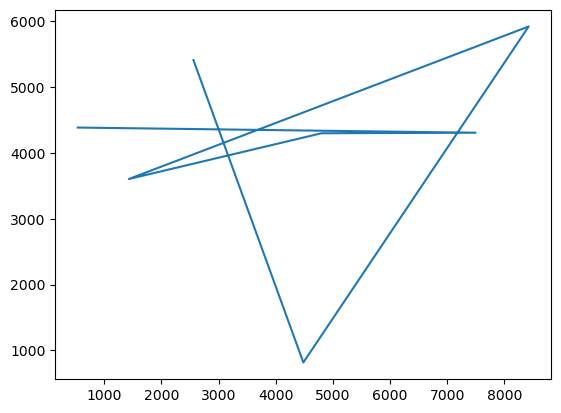

In [44]:
plt.plot(Tracks[Tracks.cell==4].xt, Tracks[Tracks.cell==4].yt)

In [ ]:
ds